In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
import sunode
import sunode.wrappers.as_aesara
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print

In [3]:

times = np.arange(0,21, 1)
lynx_data = np.array([
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
])
hare_data = np.array([
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
])
def r2_loss(pred, y):
    r2_loss = 1 - np.square(pred - y).sum() / np.square(y - np.mean(y)).sum()
    return r2_loss

In [9]:

def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'hares': p.alpha * y.hares - p.beta * y.lynx * y.hares,
        'lynx': p.delta * y.hares * y.lynx - p.gamma * y.lynx,
    }


model = pm.Model()
with model:
    hares_start = pm.HalfNormal('hares_start', sigma=50)
    lynx_start = pm.HalfNormal('lynx_start', sigma=50)

    ratio = pm.Beta('ratio', alpha=0.5, beta=0.5)

    fixed_hares = pm.HalfNormal('fixed_hares', sigma=50)
    fixed_lynx = pm.Deterministic('fixed_lynx', ratio * fixed_hares)

    period = pm.Gamma('period', mu=10, sigma=1)
    freq = pm.Deterministic('freq', 2 * np.pi / period)

    log_speed_ratio = pm.Normal('log_speed_ratio', mu=0, sigma=0.1)
    speed_ratio = np.exp(log_speed_ratio)

    # Compute the parameters of the ode based on our prior parameters
    alpha = pm.Deterministic('alpha', freq * speed_ratio * ratio)
    beta = pm.Deterministic('beta', freq * speed_ratio / fixed_hares)
    gamma = pm.Deterministic('gamma', freq / speed_ratio / ratio)
    delta = pm.Deterministic('delta', freq / speed_ratio / fixed_hares / ratio)
    
    
    # alpha = pm.HalfNormal('alpha', sigma=1)
    # beta = pm.HalfNormal('beta', sigma=0.05)
    # gamma = pm.HalfNormal('gamma', sigma=2.2)
    # delta = pm.HalfNormal('delta', sigma=0.07)
    
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_aesara.solve_ivp(
        y0={
            # The initial conditions of the ode. Each variable
            # needs to specify a theano or numpy variable and a shape.
            # This dict can be nested.
            'hares': (hares_start, ()),
            'lynx': (lynx_start, ()),
        },
        params={
            # Each parameter of the ode. sunode will only compute derivatives
            # with respect to theano variables. The shape needs to be specified
            # as well. It it infered automatically for numpy variables.
            # This dict can be nested.
            'alpha': (alpha, ()),
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'delta': (delta, ()),
            'extra': np.zeros(1),
        },
        # A functions that computes the right-hand-side of the ode using
        # sympy variables.
        rhs=lotka_volterra,
        # The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )

    
    sd = pm.HalfNormal('sd')
    # pm.LogNormal('hares', mu=y_hat['hares'], sigma=sd, observed=hare_data)
    # pm.LogNormal('lynx', mu=y_hat['lynx'], sigma=sd, observed=lynx_data)
    
    
    pm.Normal('hares', mu=y_hat['hares'], sigma=sd, observed=hare_data)
    pm.Normal('lynx', mu=y_hat['lynx'], sigma=sd, observed=lynx_data)
    
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('hares_mu', y_hat['hares'])
    pm.Deterministic('lynx_mu', y_hat['lynx'])
    
    
    


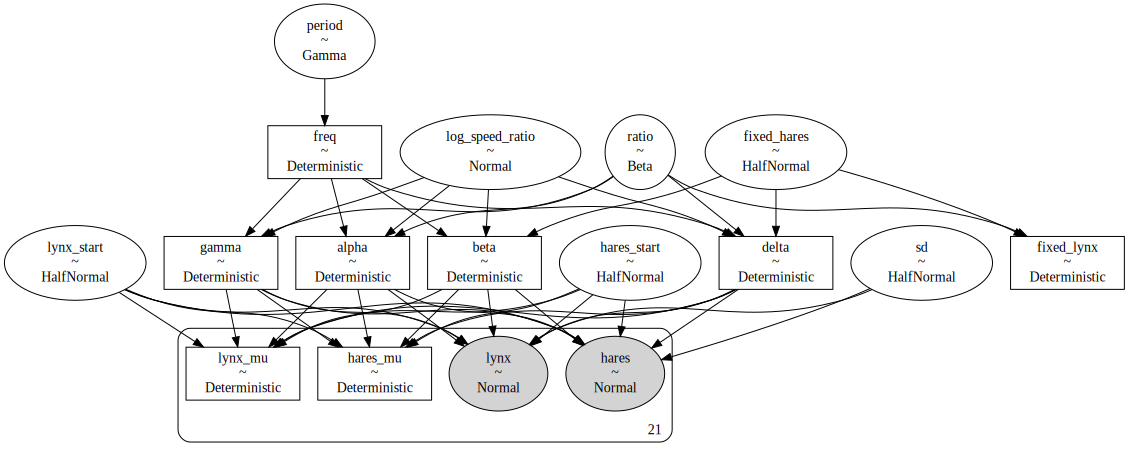

In [10]:
pm.model_to_graphviz(model)


In [11]:
with model:
    idata = pm.sample(tune=1000, draws=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hares_start, lynx_start, ratio, fixed_hares, period, log_speed_ratio, sd]



[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=2000.0 (bytes/sec)
ServerApp.rate_limit_window=1.0 (secs)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 406 seconds.


In [12]:
result_df = az.summary(idata)
result_df


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_speed_ratio,0.172,0.051,0.073,0.265,0.001,0.001,3509.0,2476.0,1.0
hares_start,35.253,1.372,32.834,38.008,0.034,0.024,1596.0,2230.0,1.0
lynx_start,3.763,0.530,2.837,4.828,0.011,0.008,2325.0,2227.0,1.0
ratio,0.581,0.027,0.527,0.627,0.001,0.000,1954.0,2321.0,1.0
fixed_hares,33.597,0.781,32.147,35.053,0.018,0.013,1915.0,2160.0,1.0
period,9.410,0.088,9.256,9.583,0.002,0.001,2613.0,2500.0,1.0
sd,3.582,0.328,2.956,4.175,0.006,0.005,2728.0,2279.0,1.0
fixed_lynx,19.505,0.762,18.067,20.901,0.015,0.010,2656.0,2837.0,1.0
freq,0.668,0.006,0.656,0.679,0.000,0.000,2613.0,2500.0,1.0
alpha,0.461,0.030,0.409,0.521,0.001,0.000,2189.0,2495.0,1.0


'r2_all:0.9654968091093126'

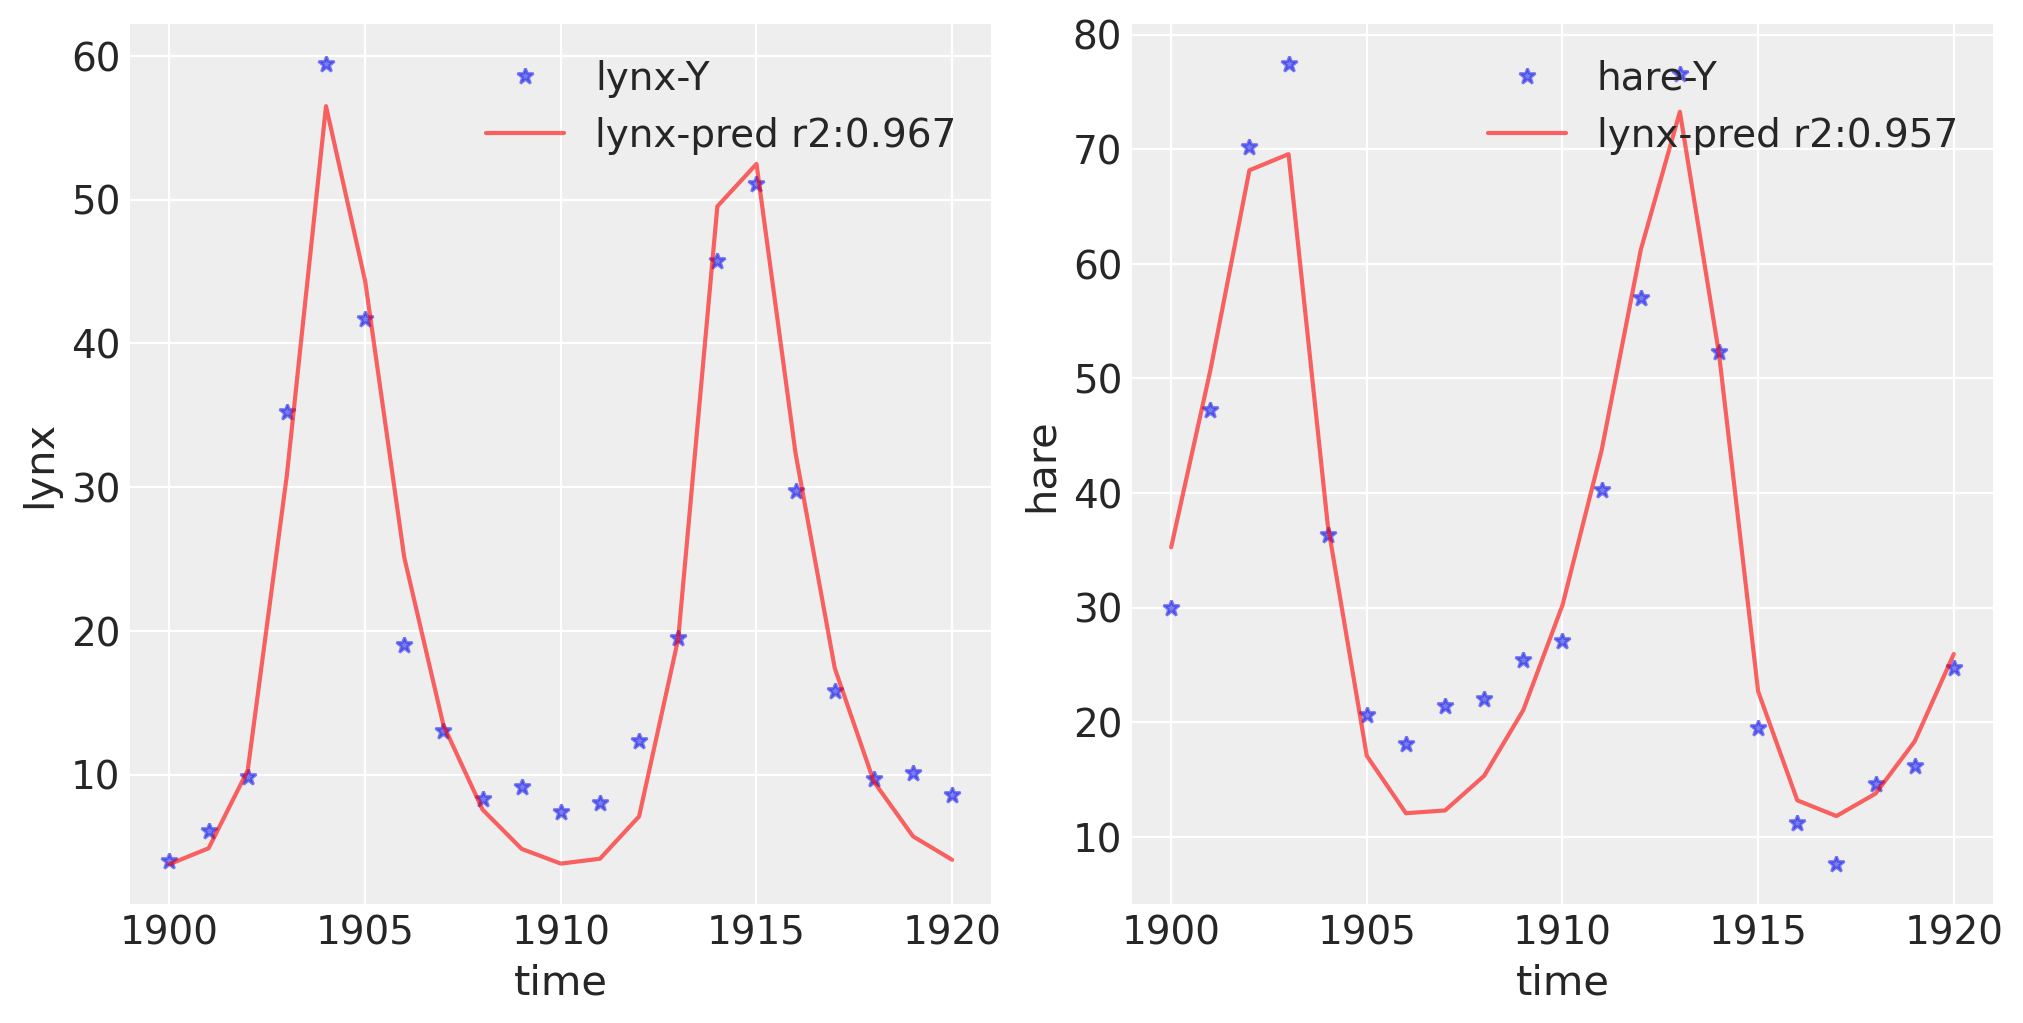

In [13]:
result_df = az.summary(idata)
para_names = ['alpha']

paras= [result_df['mean']['alpha'], result_df['mean']['beta'],result_df['mean']['delta'],result_df['mean']['gamma']]

lynx_pred,hare_pred = [],[]
lynx_name = [f"lynx_mu[{x}]" for x in range(len(lynx_data)) ]
hare_name = [f"hares_mu[{x}]" for x in range(len(hare_data)) ]
for _ly, _ha in zip(lynx_name, hare_name):
    # lynx_pred.append(np.exp(result_df['mean'][_ly] + result_df['sd'][_ly] **2 /2))
    # hare_pred.append(np.exp(result_df['mean'][_ha] + result_df['sd'][_ha] **2 /2))
    
    # lynx_pred.append(np.exp(result_df['mean'][_ly]))
    # hare_pred.append(np.exp(result_df['mean'][_ha]))
    
    
    lynx_pred.append(result_df['mean'][_ly])
    hare_pred.append(result_df['mean'][_ha])
    
    

lynx_pred,hare_pred = np.array(lynx_pred),np.array(hare_pred)


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
axes[0].plot(times, lynx_data, '*',  alpha=0.6, label='lynx-Y')
axes[1].plot(times, hare_data, '*', alpha=0.6, label='hare-Y')
axes[0].plot(times,lynx_pred,'r', alpha=0.6, label=f'lynx-pred r2:{r2_loss(lynx_data,lynx_pred):.3f}')
axes[1].plot(times, hare_pred, 'r', alpha=0.6, label=f'lynx-pred r2:{r2_loss(hare_data,hare_pred):.3f}')
axes[0].set_xlabel('time')
axes[1].set_xlabel('time')
axes[0].set_ylabel('lynx')
axes[1].set_ylabel('hare')
axes[0].legend()
axes[1].legend()

r2 = r2_loss(np.array([hare_data, lynx_data]), np.array([hare_pred, lynx_pred]))
print(f"r2_all:{r2}")



In [ ]:
# _ = az.plot_trace(idata, combined=True)

In [ ]:
def diffs(t, y, paras):
    h = y[0]
    l = y[1]
    dh = paras[0] * h - paras[1] * l * h
    dl = paras[2] * h*l - paras[3] * l
    return [dh, dl]


c0 = [result_df['mean']['hares_start'], result_df['mean']['lynx_start']]

sol_res = solve_ivp(diffs, (times.min(), times.max()), c0, t_eval=times, method='Radau', args=(paras, ))
cs = sol_res.y
t_eval = sol_res.t

cs


In [ ]:
np.abs(cs - np.array([hare_pred, lynx_pred])).sum()